In [ ]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.base import clone
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
drive.mount('/content/gdrive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Mounted at /content/gdrive


In [ ]:
def preprocess_text(text):
    text = text.lower()  # Conversie la litere mici
    text = re.sub(r'\d+', '', text)  # Eliminarea numerelor
    text = re.sub(r'\s+', ' ', text)  # Eliminarea spațiilor suplimentare
    text = re.sub(r'[^\w\s]', '', text)  # Eliminarea semnelor de punctuație

    # Eliminarea cuvintelor comune (stopwords) și lematizare
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    return ' '.join(words)


In [ ]:
class AdaBoost:
    def __init__(self, n_estimators=50, learning_rate=0.2, base_estimator=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.base_estimator = base_estimator if base_estimator is not None else DecisionTreeClassifier(max_depth=3)
        self.alphas = []
        self.models = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        w = np.ones(n_samples) / n_samples
        y = 2 * y - 1  # Convert to +1, -1

        for i in range(self.n_estimators):
            model = clone(self.base_estimator)
            model.fit(X, y, sample_weight=w)
            y_pred = model.predict(X)

            # Compute error and alpha
            err = w[(y_pred != y)].sum()
            err = err / w.sum() if w.sum() != 0 else err
            alpha = self.learning_rate  * np.log((1 - err) / (err + 1e-10))

            # Update sample weights
            w *= np.exp(-alpha * y * y_pred)
            w /=  w.sum()  # Normalize weights
            print(f"Estimator {i + 1}:")
            print(f"Weighted error: {err}")
            print(f"Alpha: {alpha}")
            print(f"Sample weights: {w[:5]}")
            print("pozition",np.argpartition(w, -5)[-5:],"value",w[np.argpartition(w, -5)[-5:]])
            # Save the model and alpha
            self.models.append(model)
            self.alphas.append(alpha)

    def predict_proba(self, X):
        # Aggregate predictions from all models
        model_preds = np.array([alpha * model.predict(X) for alpha, model in zip(self.alphas, self.models)])
        decision_scores = np.sum(model_preds, axis=0)
        proba = 1 / (1 + np.exp(-decision_scores))
        print("score:",decision_scores,"probability:",proba)
        return proba

    def predict(self, X):
        proba = self.predict_proba(X)

        return np.where(proba >= 0.5, 1, -1)

In [ ]:
class GradientBoosting():
    def __init__(self,n_estimators = 50,learning_rate = 0.3,base_estimator = None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.base_estimator = base_estimator if base_estimator is not None else DecisionTreeRegressor(max_depth=3)
        self.models = []

    def fit(self, X, y):
        self.init_prediction = np.mean(y)
        current_prediction = np.full(y.shape, self.init_prediction)


        for _ in range(self.n_estimators):
            # Compute residuals (pseudo-residuals)
            residuals = y - current_prediction
            # Train a weak learner on the residuals
            model = clone(self.base_estimator)
            model.fit(X, residuals)

            # Update the current prediction
            update = model.predict(X)
            current_prediction += self.learning_rate * update
            print("vector de predictii:",current_prediction[:10])
            print("estimatorul:",_)
            # Save the model
            self.models.append(model)

    def predict(self, X):
        # Start with the initial prediction
        prediction = np.full((X.shape[0],), self.init_prediction)

        # Add contributions from all weak learners
        for model in self.models:
            prediction += self.learning_rate * model.predict(X)
        print("vectorul final de predictii:",prediction[:10])

        # Convert predictions to probabilities using the sigmoid function

        # Convert probabilities to {0, 1} by thresholding at 0.5
        return (prediction >= 0.5).astype(int)

In [ ]:
class SupportVectorMachine():

    def __init__(self, lr_rate=0.0001, n_iters=5, lambda_param=0.1):
        self.lr_rate = lr_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        print("samples:", n_samples, "features:", n_features)
        self.w = np.zeros(n_features)
        self.b = 0
        y_ = 2 * y - 1  # Transformăm etichetele în {-1, 1}
        for i in range(self.n_iters):
            print("Iteration:", i)
            for nr, x in enumerate(X):
                condition = y_[nr] * (np.dot(x, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr_rate * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr_rate * (2 * self.lambda_param * self.w - np.dot(x, y_[nr]))
                    self.b -= self.lr_rate * y_[nr]
                # if condition: #codsat
                #     self.w -= self.lr_rate * (2 * self.lambda_param * self.w)
                # else:
                #     self.w -= self.lr_rate * (2 * self.lambda_param * self.w - np.dot(x, y[nr]))
                #     self.b -= self.lr_rate * y[nr]
            print(f"Sample weights after iteration {i}: {self.w[:5]}")
        print("Final weights:", self.w)
        print("Final bias:", self.b)

    def predict(self, X):
        linear_output = np.dot(X, self.w) - self.b
        print("Linear output values:", linear_output)  # Afișează valorile calculate
        print("Min value of linear output:", np.min(linear_output))  # Verifică minimul
        print("Max value of linear output:", np.max(linear_output))  # Verifică maximul
        print("Predicted values:", np.unique(np.sign(linear_output)))
        return np.sign(linear_output)


In [ ]:
df = pd.read_csv(r"/content/gdrive/MyDrive/Spam/Spam_database/spam_ham_dataset.csv")
df["text"] = df["text"].apply(lambda x:preprocess_text(x))
print(df.text.iloc[0])
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(df.text).toarray()
y = df["label_num"].values
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25, random_state=42,shuffle=True)
svm_model = SupportVectorMachine(lr_rate=0.001, n_iters=5, lambda_param=0.01)

# Train SVM

modelBoost = GradientBoosting()
modelBoost.fit(x_train, y_train)
modelA = AdaBoost()
modelA.fit(x_train, y_train)
svm_model.fit(x_train, y_train)

y_predict_svm = svm_model.predict(x_test)
accuracy_svm = accuracy_score(y_test*2-1, y_predict_svm)
precision_svm = precision_score(y_test*2-1, y_predict_svm)
recall_svm = recall_score(y_test*2-1, y_predict_svm)
f1_svm = f1_score(y_test*2-1, y_predict_svm)
roc_auc_svm = roc_auc_score(y_test*2-1, y_predict_svm)
# Calculate metrics for Gradient Boosting
y_predictB = modelBoost.predict(x_test)
accuracyB = accuracy_score(y_test, y_predictB)
precisionB = precision_score(y_test, y_predictB)
recallB = recall_score(y_test, y_predictB)
f1B = f1_score(y_test, y_predictB)
roc_aucB = roc_auc_score(y_test, y_predictB)

# Calculate metrics for AdaBoost
y_predictA = modelA.predict(x_test)
accuracyA = accuracy_score(y_test*2 -1, y_predictA)
precisionA = precision_score(y_test*2 -1, y_predictA)
recallA = recall_score(y_test*2 -1, y_predictA)
f1A = f1_score(y_test*2 -1, y_predictA)
roc_aucA = roc_auc_score(y_test*2 -1, y_predictA)
roc_aucA = roc_auc_score(y_test*2 -1, y_predictA)

# Display the results in a tabular format
results = pd.DataFrame({
    "Model": ["Gradient Boosting", "AdaBoost", "SVM"],
    "Accuracy": [accuracyB, accuracyA, accuracy_svm],
    "Precision": [precisionB, precisionA, precision_svm],
    "Recall": [recallB, recallA, recall_svm],
    "F1-Score": [f1B, f1A, f1_svm],
    "AUC-ROC": [roc_aucB, roc_aucA, roc_auc_svm]
})


subject enron methanol meter follow note gave monday preliminary flow data provided daren please override pop daily volume presently zero reflect daily activity obtain gas control change needed asap economics purpose
vector de predictii: [0.33213634 0.33213634 0.20505415 0.33213634 0.20505415 0.33213634
 0.22005415 0.33213634 0.20505415 0.22005415]
estimatorul: 0
vector de predictii: [0.3952789  0.3952789  0.14353791 0.3952789  0.14353791 0.23249544
 0.28319672 0.3952789  0.14353791 0.28319672]
estimatorul: 1
vector de predictii: [0.37252053 0.37252053 0.12077953 0.37252053 0.12077953 0.20973706
 0.26043834 0.37252053 0.12077953 0.26043834]
estimatorul: 2
vector de predictii: [0.41822203 0.41822203 0.08404777 0.41822203 0.08404777 0.25543856
 0.22623611 0.41822203 0.08657729 0.22623611]
estimatorul: 3
vector de predictii: [0.45555388 0.45555388 0.06047081 0.45555388 0.04727744 0.16729077
 0.18554344 0.45555388 0.04980696 0.26356795]
estimatorul: 4
vector de predictii: [0.60516241 0.447

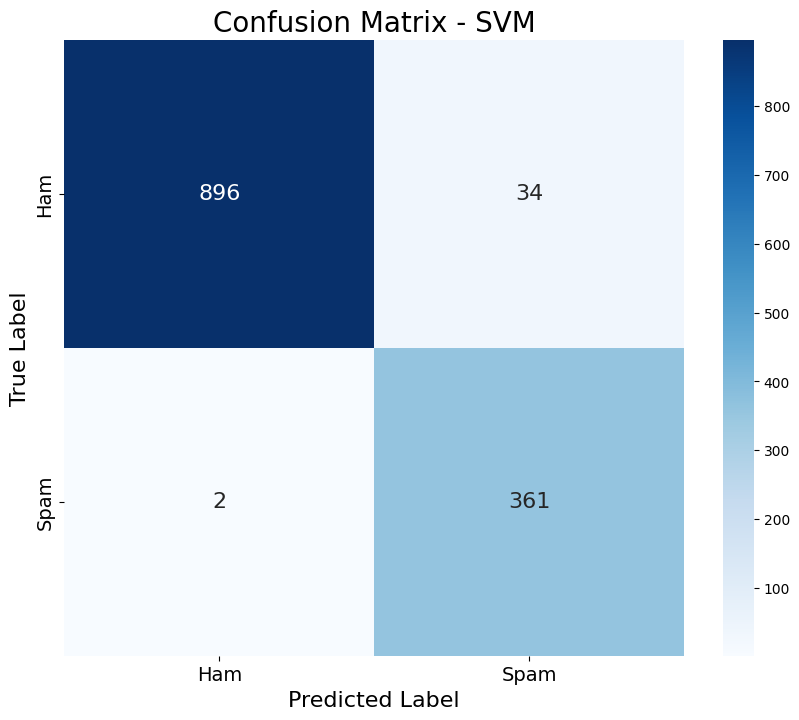

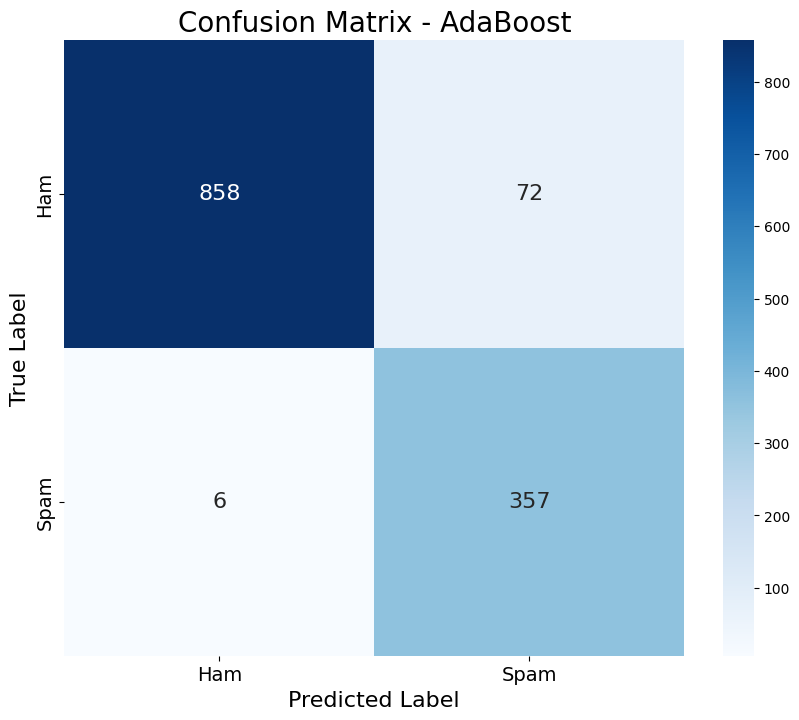

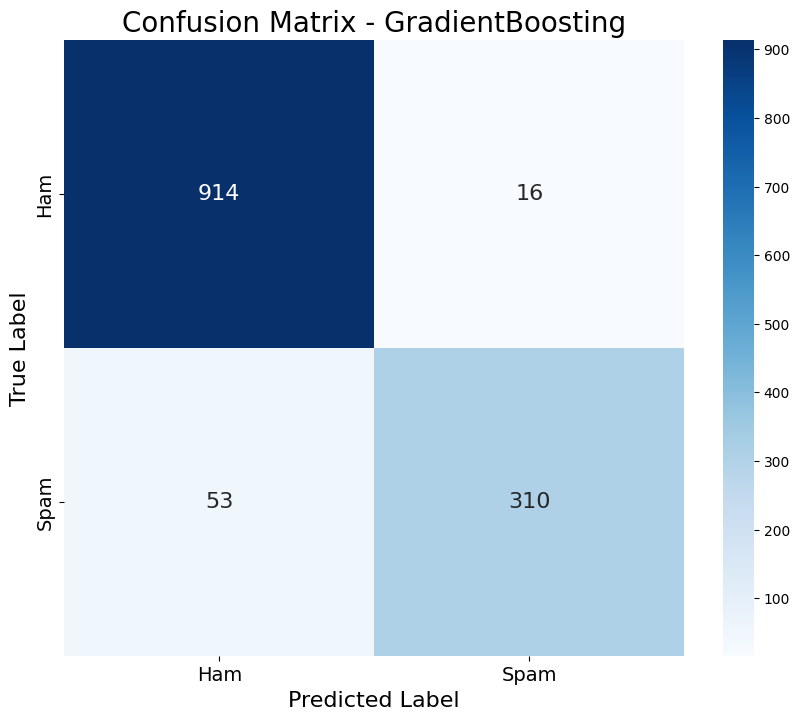

               Model  Accuracy  Precision    Recall  F1-Score   AUC-ROC
0  Gradient Boosting  0.946636   0.950920  0.853994  0.899855  0.918395
1           AdaBoost  0.939675   0.832168  0.983471  0.901515  0.953026
2                SVM  0.972158   0.913924  0.994490  0.952507  0.978966


In [ ]:
conf_matrix_svm = confusion_matrix(y_test*2-1, y_predict_svm)
conf_matrix_adaboost = confusion_matrix(y_test*2-1, y_predictA)
conf_matrix_Xgboost = confusion_matrix(y_test, y_predictB)

# Funcție pentru afișarea matricii de confuzie ca heatmap cu scris mai mare
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(10, 8))  # Dimensiunea figurii
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'],
                annot_kws={"size": 16})  # Dimensiunea textului în celule
    plt.title(title, fontsize=20)  # Dimensiunea titlului
    plt.xlabel('Predicted Label', fontsize=16)  # Dimensiunea textului pe axa X
    plt.ylabel('True Label', fontsize=16)  # Dimensiunea textului pe axa Y
    plt.xticks(fontsize=14)  # Dimensiunea etichetelor axei X
    plt.yticks(fontsize=14)  # Dimensiunea etichetelor axei Y
    plt.show()

# Afișarea matricilor de confuzie ca heatmaps
plot_confusion_matrix(conf_matrix_svm, "Confusion Matrix - SVM")
plot_confusion_matrix(conf_matrix_adaboost, "Confusion Matrix - AdaBoost")
plot_confusion_matrix(conf_matrix_Xgboost, "Confusion Matrix - GradientBoosting")

print(results)
